<a href="https://colab.research.google.com/github/kimdesok/Text-classification/blob/main/Spam_Classfication_Bayesians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
import string

from nltk.stem.porter import PorterStemmer
#from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, classification_report

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#DIR_PATH = r"/home/ubuntu/Kaggle2/Data"
DIR_PATH = r"/content/spam.csv"

#load the dataframe
df = pd.read_csv(DIR_PATH, encoding='latin-1')
df.head()

print("Data frame shape, ", df.shape)


Data frame shape,  (5572, 5)


In [ ]:
# Data cleaning
df.info()

# Drop the last three columns
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

# Renaming columns
df.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)

labelen = LabelEncoder()
df['target'] = labelen.fit_transform(df['target'])
df.head()

print("Null, ", df.isnull)

df.duplicated().sum()

df.drop_duplicates(keep='first')

df = df.drop_duplicates(keep='first')

print("no of duplicates,", len(df.duplicated()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
Null,  <bound method DataFrame.isnull of       target                                               text
0          0  Go until jurong point, crazy.. Available only ...
1          0                      Ok lar... Joking wif u oni...
2          1  Free entry in 2 a wkly comp to win FA Cup fina...
3          0  U dun say so early hor... U c already then say...
4          0  Nah I don't think he goes to usf, he lives aro...
...      ...                                                ...
5567       1  This is the 2nd time we have tried 2 contact u...
5568       0       

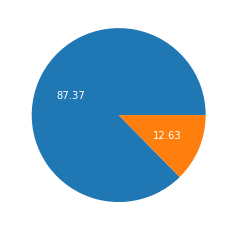

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


   target                                               text  num_chars  \
0       0  Go until jurong point, crazy.. Available only ...        111   
1       0                      Ok lar... Joking wif u oni...         29   
2       1  Free entry in 2 a wkly comp to win FA Cup fina...        155   
3       0  U dun say so early hor... U c already then say...         49   
4       0  Nah I don't think he goes to usf, he lives aro...         61   

   words  sentences  
0     24          2  
1      8          2  
2     37          2  
3     13          1  
4     15          1  


,target,num_chars,words,sentences
count,5169.000000,5169.000000,5169.000000,5169.000000
mean,0.126330,78.977945,18.455794,1.965564
std,0.332253,58.236293,13.324758,1.448541
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,36.000000,9.000000,1.000000
50%,0.000000,60.000000,15.000000,1.000000
75%,0.000000,117.000000,26.000000,2.000000
max,1.000000,910.000000,220.000000,38.000000


In [ ]:
# EDA
# No. of hams and spams
df['target'].value_counts()

#pie chart
plt.pie(df['target'].value_counts(), labels=['Ham','Spam'], autopct='%0.2f', textprops=dict(color="w"))
plt.show()

nltk.download('punkt')

df['text'].apply(len)

# Number of characters
df['num_chars'] = df['text'].apply(len)
#print(df.head())

df['words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df['sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

print(df.head())

df.describe()

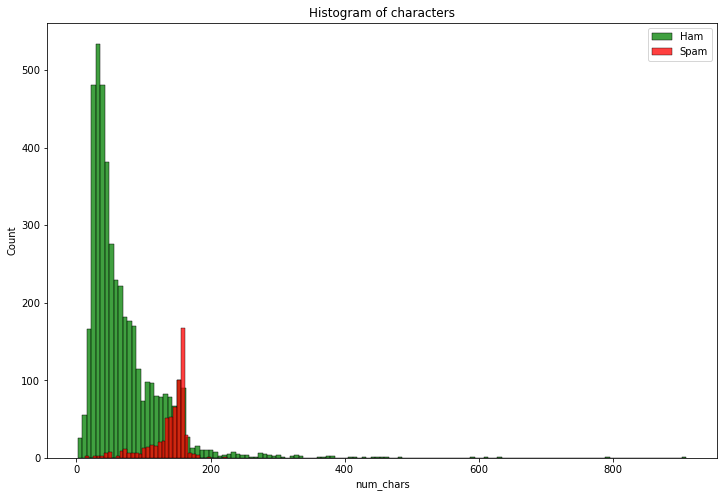

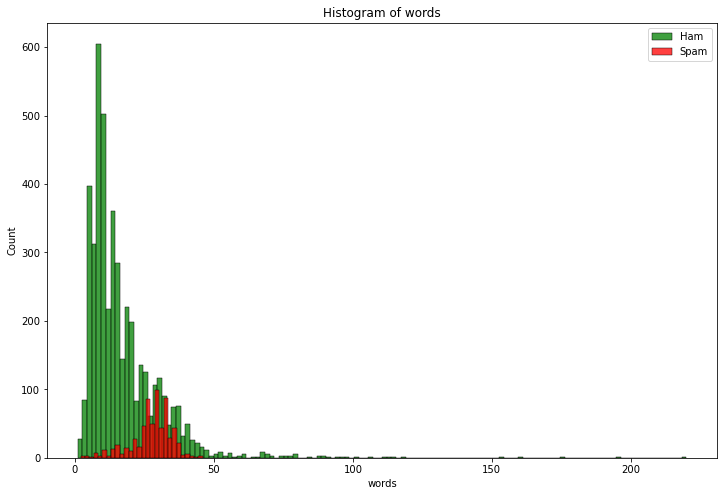

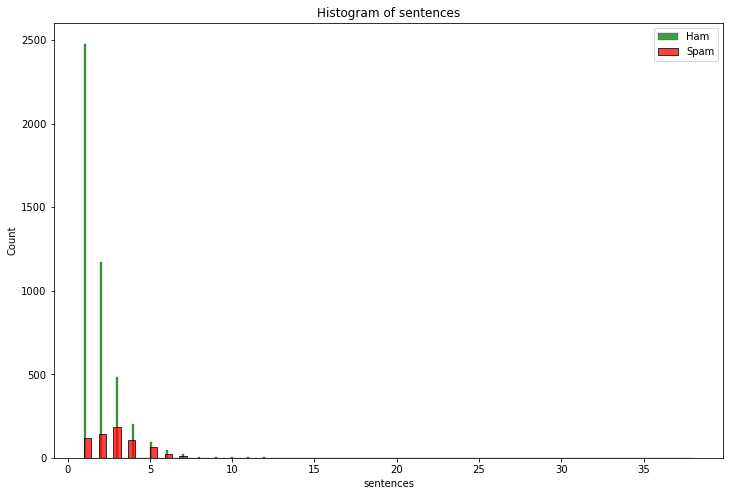

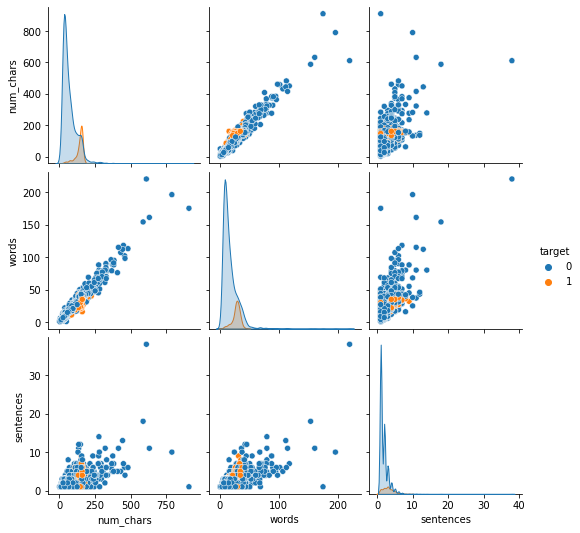

In [ ]:
# Summary description of ham & spams
df[df['target'] == 0].describe()
df[df['target'] == 1].describe()

#histograms
plt.figure(figsize=(12, 8))
sns.histplot(df[df['target'] == 0]['num_chars'], color = 'green').set(title='Histogram of characters')
sns.histplot(df[df['target'] == 1]['num_chars'], color = 'red')
plt.legend(labels=['Ham', 'Spam'])

plt.figure(figsize=(12, 8))
sns.histplot(df[df['target'] == 0]['words'], color = 'green').set(title='Histogram of words')
sns.histplot(df[df['target'] == 1]['words'], color = 'red')
plt.legend(labels=['Ham', 'Spam'])

plt.figure(figsize=(12, 8))
sns.histplot(df[df['target'] == 0]['sentences'], color = 'green').set(title='Histogram of sentences')
sns.histplot(df[df['target'] == 1]['sentences'], color = 'red')
plt.legend(labels=['Ham', 'Spam'])

sns.pairplot(df, hue='target')

<AxesSubplot:>

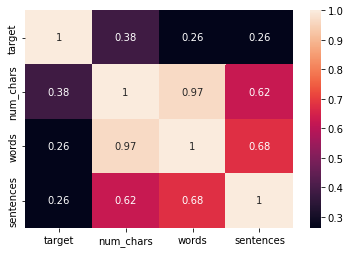

In [ ]:
sns.heatmap(df.corr(), annot=True)

In [ ]:
# Data processing
nltk.download('stopwords')
len(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


179

In [ ]:
def transform_txt(text):
    text = text.lower() #lowercasing
    text = nltk.word_tokenize(text) #tokenization
    lis = []
    for i in text:
        if i.isalnum():
            lis.append(i) #special characters removal
    text = lis[:]
    lis.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            lis.append(i)
    return " ".join(lis)

print(transform_txt("Hello. How are you, Carlos?"))

hello carlos


In [ ]:
from wordcloud import WordCloud

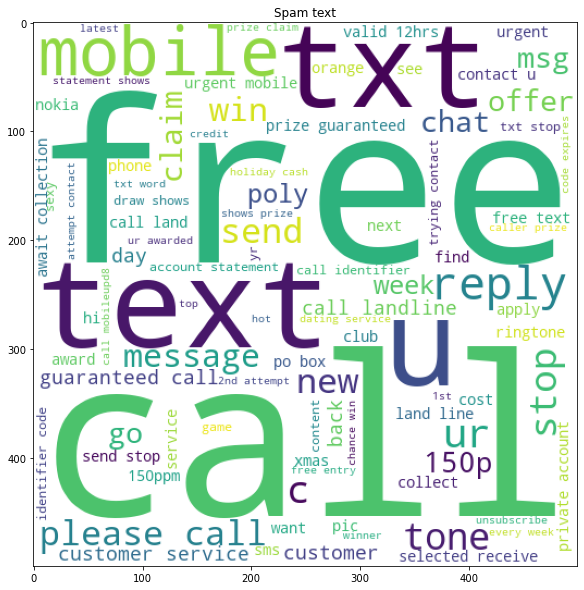

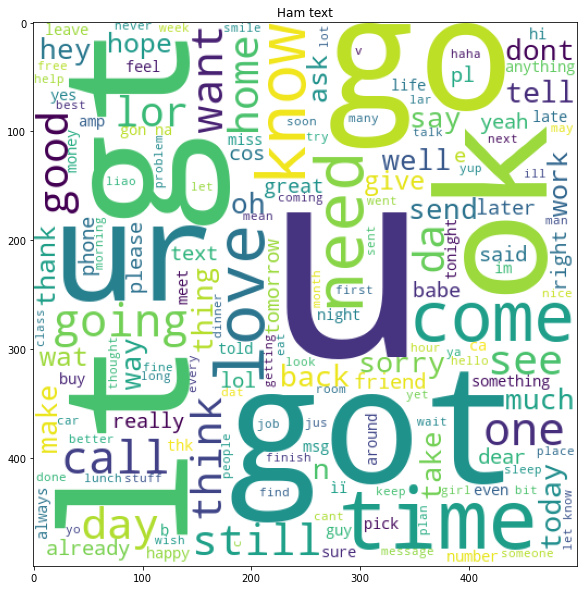

In [ ]:
ps = PorterStemmer()
ps.stem('dancing')

df['transformed_text'] = df['text'].apply(transform_txt)

wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

plt.figure(figsize=(30, 10))
plt.title("Spam text")
plt.imshow(spam_wc)


wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

plt.figure(figsize=(30,10))
plt.title("Ham text")
plt.imshow(ham_wc)
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]),
 [Text(0, 0, 'call'),
  Text(1, 0, 'free'),
  Text(2, 0, '2'),
  Text(3, 0, 'txt'),
  Text(4, 0, 'u'),
  Text(5, 0, 'ur'),
  Text(6, 0, 'mobile'),
  Text(7, 0, 'text'),
  Text(8, 0, 'stop'),
  Text(9, 0, '4'),
  Text(10, 0, 'claim'),
  Text(11, 0, 'reply'),
  Text(12, 0, 'prize'),
  Text(13, 0, 'get'),
  Text(14, 0, 'new'),
  Text(15, 0, 'send'),
  Text(16, 0, 'urgent'),
  Text(17, 0, 'nokia'),
  Text(18, 0, 'cash'),
  Text(19, 0, 'contact'),
  Text(20, 0, 'please'),
  Text(21, 0, 'service'),
  Text(22, 0, 'win'),
  Text(23, 0, 'c'),
  Text(24, 0, 'phone'),
  Text(25, 0, 'guaranteed'),
  Text(26, 0, 'per'),
  Text(27, 0, 'week'),
  Text(28, 0, 'customer'),
  Text(29, 0, 'tone'),
  Text(30, 0, 'chat'),
  Text(31, 0, 'cs'),
  Text(32, 0, 'draw'),
  Text(33, 0, 'mins'),
  Text(34, 0, 'awarded')])

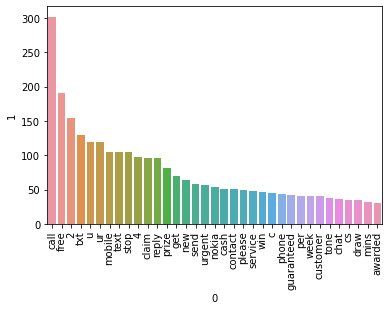

In [ ]:
#import re
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        #m = re.findall(r'\d+\.\d+', word)
        spam_corpus.append(word)

cw = Counter(spam_corpus).most_common(35)
dfx = pd.DataFrame(cw)
sns.barplot(data=dfx, x=dfx[0], y=dfx[1])
plt.xticks(rotation = 'vertical')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]),
 [Text(0, 0, 'u'),
  Text(1, 0, 'get'),
  Text(2, 0, 'gt'),
  Text(3, 0, 'lt'),
  Text(4, 0, '2'),
  Text(5, 0, 'go'),
  Text(6, 0, 'got'),
  Text(7, 0, 'know'),
  Text(8, 0, 'like'),
  Text(9, 0, 'ok'),
  Text(10, 0, 'good'),
  Text(11, 0, 'come'),
  Text(12, 0, 'ur'),
  Text(13, 0, 'time'),
  Text(14, 0, 'call'),
  Text(15, 0, 'love'),
  Text(16, 0, 'day'),
  Text(17, 0, 'going'),
  Text(18, 0, 'want'),
  Text(19, 0, 'lor'),
  Text(20, 0, 'one'),
  Text(21, 0, '4'),
  Text(22, 0, 'home'),
  Text(23, 0, 'need'),
  Text(24, 0, 'still'),
  Text(25, 0, 'da'),
  Text(26, 0, 'see'),
  Text(27, 0, 'back'),
  Text(28, 0, 'think'),
  Text(29, 0, 'today'),
  Text(30, 0, 'sorry'),
  Text(31, 0, 'n'),
  Text(32, 0, 'r'),
  Text(33, 0, 'dont'),
  Text(34, 0, 'tell')])

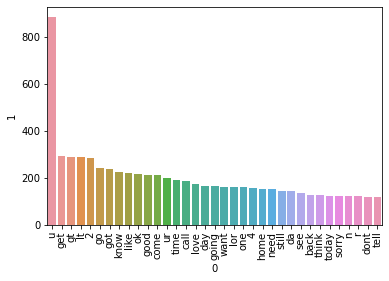

In [ ]:
#import re
spam_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        #m = re.findall(r'\d+\.\d+', word)
        spam_corpus.append(word)

cw = Counter(spam_corpus).most_common(35)
dfx = pd.DataFrame(cw)
sns.barplot(data=dfx, x=dfx[0], y=dfx[1])
plt.xticks(rotation = 'vertical')

In [ ]:
# ML Model Algorithms

# Convert a collection of text documents to a matrix of token counts.
cv = CountVectorizer()
print(df['transformed_text'][:5])
cv.fit(df['transformed_text'])
    #print(cv.get_feature_names()) 
    #print(cv.vocabulary_) 
X = cv.transform(df['transformed_text'])
    #X = cv.fit_transform(df['transformed_text'])
print("X Shape, ", X.shape)
print(X[0])
    #print(X[1])

X = X.toarray()

#print(X[0].tolist())

y = df['target'].values
print(y[:5])

#Load train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry 2 wkly comp win fa cup final tkts 2...
3                  u dun say early hor u c already say
4               nah think goes usf lives around though
Name: transformed_text, dtype: object
X Shape,  (5169, 8002)
  (0, 869)	1
  (0, 1087)	1
  (0, 1513)	1
  (0, 1515)	1
  (0, 1796)	1
  (0, 2058)	1
  (0, 3223)	1
  (0, 3266)	1
  (0, 3302)	1
  (0, 3964)	1
  (0, 4084)	1
  (0, 5426)	1
  (0, 7646)	1
  (0, 7842)	1
[0 0 1 0 0]


Accuracy Score: 0.8858800773694391
Precision Score:  0.5594713656387665


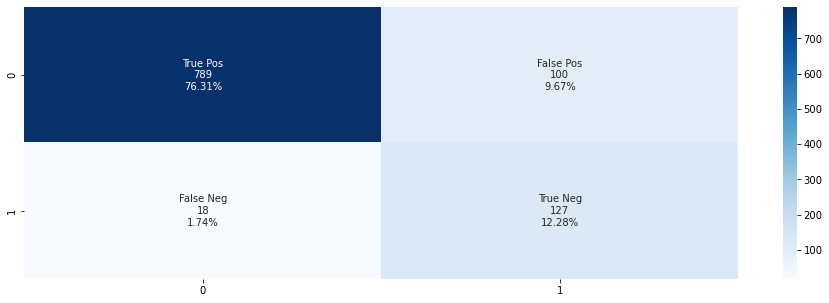

In [ ]:
def confusion_mat(Y_test, pred_test_DT): #Confusion matrix printing function
    group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
    test_cnf_matrix = confusion_matrix(Y_test,pred_test_DT)
    test_counts = ["{0:0.0f}".format(value) for value in test_cnf_matrix.flatten()]
    test_percentage = ["{0:.2%}".format(value) for value in test_cnf_matrix .flatten()/np.sum(test_cnf_matrix)]
    test_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,test_counts,test_percentage)]
    test_labels = np.asarray(test_labels).reshape(2,2)
    plt.figure(figsize = (16,5))
    sns.heatmap(test_cnf_matrix, annot=test_labels, fmt='', cmap='Blues')

# Naive Bayesians

gunb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

gunb.fit(X_train, y_train)
y_pred1 = gunb.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred1))
print("Precision Score: ", precision_score(y_test, y_pred1))
confusion_mat(y_test, y_pred1)

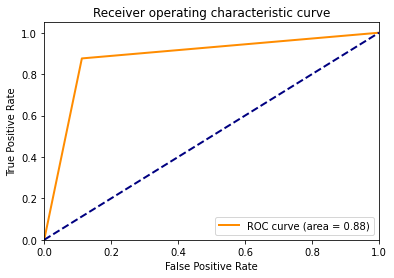

In [ ]:
def roc_auc(y_test, y_pred, model):
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()
    
roc_auc(y_test, y_pred1, gunb)

Accuracy Score: 0.9738878143133463
Precision Score:  0.8881578947368421


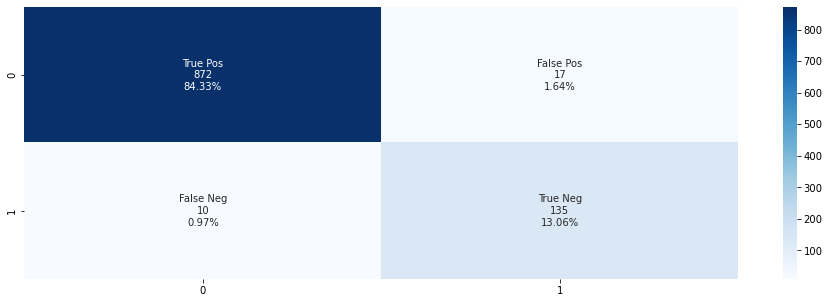

In [ ]:
mnb = MultinomialNB()

mnb.fit(X_train, y_train)
y_pred1 = mnb.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred1))
print("Precision Score: ", precision_score(y_test, y_pred1))
confusion_mat(y_test, y_pred1)

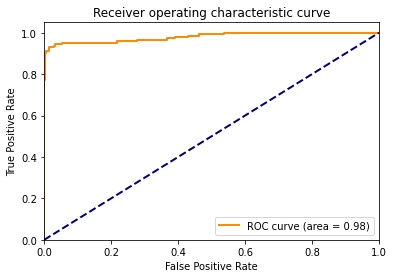

In [ ]:
roc_auc(y_test, y_pred1, mnb)

Accuracy Score: 0.9642166344294004
Precision Score:  0.9736842105263158


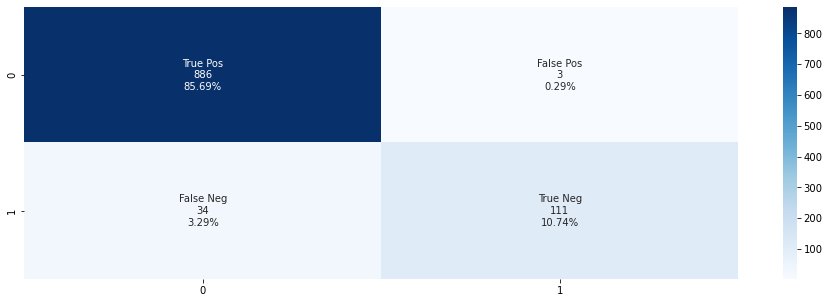

In [ ]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
y_pred1 = bnb.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred1))
print("Precision Score: ", precision_score(y_test, y_pred1))
confusion_mat(y_test, y_pred1)

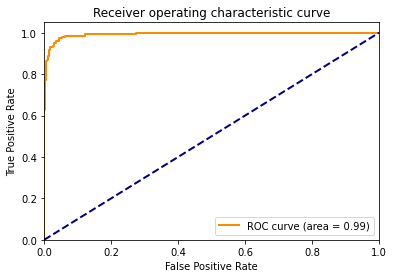

In [ ]:
roc_auc(y_test, y_pred1, bnb)